# compute spectra on mitgcm outputs

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.235:8786 Dashboard: http://10.148.0.235:8787/status,Cluster Workers: 6 Cores: 84 Memory: 600.00 GB


--- 

# load data SSU

In [6]:
## open files, nc files
ncdata_dir = scratch+'/mit_nc/'
# search for right files, for example: Eta_f01_t*.nc
print(ncdata_dir)

/home1/scratch/xyu/mit_nc/


In [7]:
v = 'SSU'

face = 1

filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
filenames = filenames[:2]
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
grid = grid.isel(face=face)
print(grid)

Number of files available: 5
Number of files processed: 2
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    XG       (i_g, j_g) float32 ...
    YG       (i_g, j_g) float32 ...
    rA       (i, j) float32 ..

In [8]:
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')

ds = ds.isel(time=slice(0,3000))
print(ds)
print('\n data size: %.3f GB' %(ds.nbytes / 1e9))


CPU times: user 40 ms, sys: 16 ms, total: 56 ms
Wall time: 485 ms
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
Data variables:
    SSU      (i, j, time) float32 dask.array<shape=(4320, 4320, 480), chunksize=(10, 432, 240)>

 data size: 35.832 GB


In [9]:
ds = xr.merge([ds,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    XG       (i_g, j_g) float32 ...
    YG       (i_g, j_g) float32 

In [10]:
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 128 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 dask.array<shape=(4320, 4320), chunks

In [11]:
%time SSU = ds['SSU'].persist()

CPU times: user 2.17 s, sys: 4 ms, total: 2.18 s
Wall time: 2.18 s


______

# Load data SSV


In [12]:
v1 = 'SSV'

face = 1

filenames_SSV = sorted(glob(ncdata_dir+v1+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames_SSV))
filenames_SSV = filenames_SSV[:2]
print('Number of files processed: %d' %len(filenames_SSV))


Number of files available: 5
Number of files processed: 2


In [13]:
%time ds_SSV = xr.open_mfdataset(filenames_SSV, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')

ds_SSV = ds_SSV.isel(time=slice(0,3000))

chunks={'time': len(ds_SSV['time'])}
%time ds_SSV = ds_SSV.chunk(chunks)

ds = xr.merge([ds_SSV,ds])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 48 ms, sys: 12 ms, total: 60 ms
Wall time: 318 ms
CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 127 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [14]:
%time SSV = ds['SSV'].persist()

CPU times: user 2.14 s, sys: 24 ms, total: 2.16 s
Wall time: 2.16 s


____

# Complex format of horizontal velocity

In [15]:
%time UV_complex = (ds['SSU'] + 1j*ds['SSV']).persist()

CPU times: user 5.52 s, sys: 56 ms, total: 5.58 s
Wall time: 6 s


In [16]:
print(UV_complex)

<xarray.DataArray (i: 4320, j: 4320, time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=complex64, chunksize=(10, 432, 480)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    XC       (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC       (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    rA       (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    Depth    (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>


---

# spectral computations 

In [17]:
# complex uv
uv_fft = xrft.dft(UV_complex.fillna(0.), dim=['time'], shift=False, detrend='linear')
E_uv = (uv_fft*uv_fft.conj()).where(uv_fft!=0., drop=False).mean(dim=('i','j'))
E_uv = E_uv.astype('f8').rename('SSUV_power_spectrum ()')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [18]:
%time E_uv.load()

CPU times: user 23.2 s, sys: 64 ms, total: 23.2 s
Wall time: 2min 21s


<xarray.DataArray 'SSUV_power_spectrum ()' (freq_time: 480)>
array([3.186533e-10, 6.950358e+02, 4.597413e+02, ..., 2.474401e+02,
       4.529519e+02, 6.966994e+02])
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07

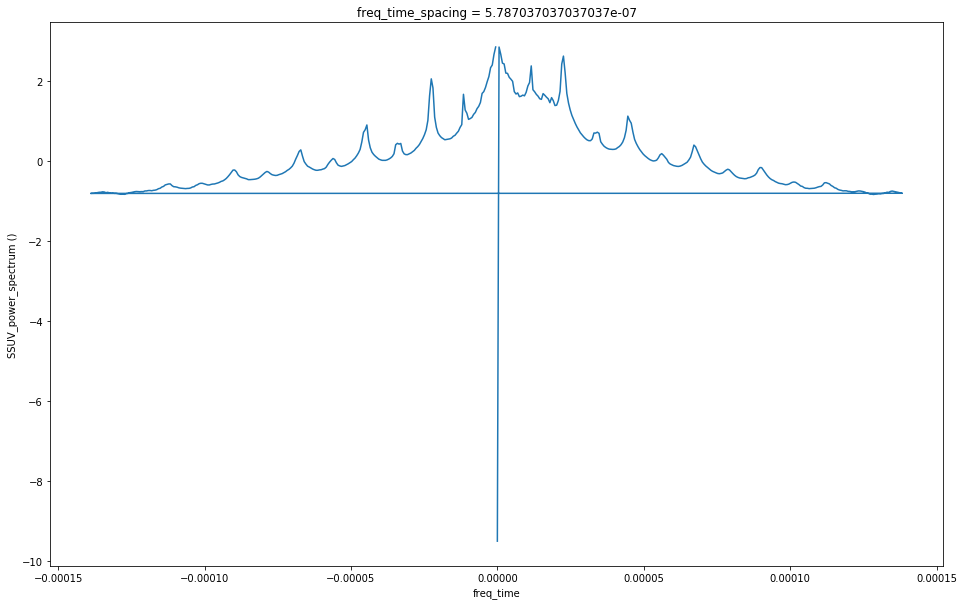

In [23]:
# Figure #
plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
E_uv = E_uv.assign_coords(freq_cpd=E_uv.freq_time * 86400.) 
np.log10(E_uv).plot(ax=ax)


No handles with labels found to put in legend.


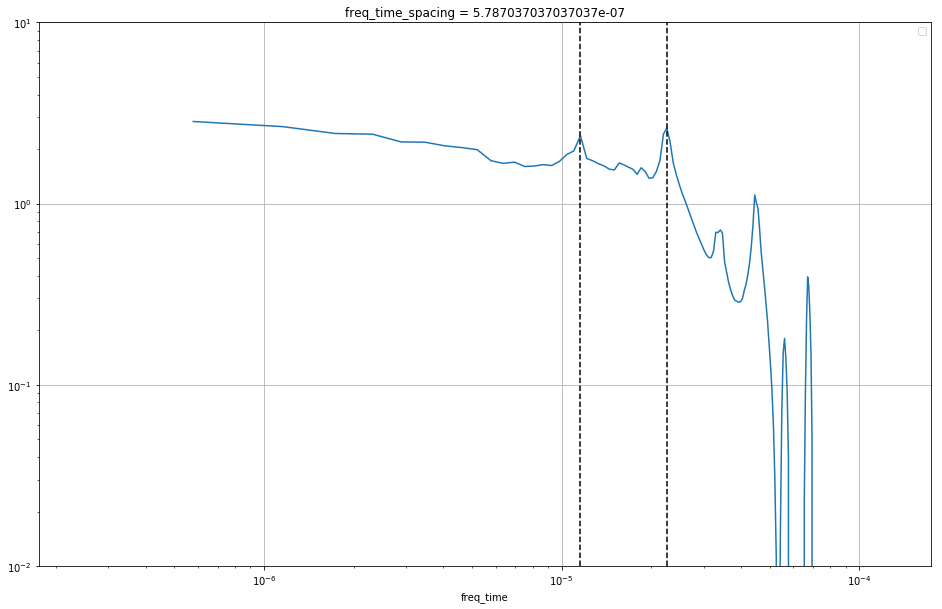

In [22]:
# Figure #
plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
E_uv = E_uv.assign_coords(freq_cpd=E_uv.freq_time * 86400.) 
np.log10(E_uv).where(E_uv.freq_time>0).plot(ax=ax)


ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
ax.set_xlim([1.75*1e-7,1.75*1e-4])
ax.set_ylim([1e-2,1e1])

# M2 #
ax.plot([1/12.24/3600,1/12.24/3600],[1e-2,1e6],'k--') 
# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')



---

In [22]:
client.restart()

Client Scheduler: tcp://10.148.0.148:8786 Dashboard: http://10.148.0.148:8787/status,Cluster Workers: 15 Cores: 210 Memory: 1500.00 GB
